In [1]:
!pip install rdkit
!pip install torch-geometric
!pip install deap

In [19]:
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch_geometric.data import Data
import torch_geometric.utils as pyg_utils
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from deap import base, tools, creator, algorithms
import copy
import random

In [8]:
# data cols
# ['sci_name','name','cid','smile','Molecular Weight','LogP','TPSA','Rotatable Bonds','H Bond Donors','H Bond Acceptors','Aromatic Rings','Num Rings','Atom Count','coulomb_matrix','embeddings']

class MoleculeVisualizer():

    def visualize_molecule_2D(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol) # add implicit hydrogens
        if mol is None:
            print("Invalid SMILES string.")
            return

        img = Draw.MolToImage(mol, size=(300, 300))

        return img

class MoleculeGraphConverter():
    """Converts SMILES strings to PyTorch Geometric graph representations."""

    @staticmethod
    def smiles_to_graph(smiles):
        """Convert a SMILES string into a graph representation."""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None  # Handle invalid molecules

        num_atoms = mol.GetNumAtoms()

        # Node features: Atomic number
        node_feats = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.float).view(-1, 1)

        # Edge indices and features
        edge_indices, edge_attrs = [], []
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            edge_indices.append((start, end))
            edge_indices.append((end, start))  # Bidirectional edges

            bond_type = bond.GetBondType()
            edge_attrs.append(float(bond_type))
            edge_attrs.append(float(bond_type))  # Bidirectional edges

        if edge_indices:
            edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_attrs, dtype=torch.float).view(-1, 1)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_attr = torch.empty((0, 1), dtype=torch.float)

        return Data(x=node_feats, edge_index=edge_index, edge_attr=edge_attr, num_nodes=num_atoms)

    @staticmethod
    def test_smiles_to_graph(self, dataset):
        """
        Tests SMILES to graph conversion for all molecules in the dataset.
        """
        errors = []
        for i, smiles in enumerate(dataset.smiles):
            try:
                graph = self.smiles_to_graph(smiles)
                if graph is None:
                    errors.append((i, smiles, "Graph conversion returned None"))
            except Exception as e:
                errors.append((i, smiles, str(e)))

        if errors:
            print(f"\n{len(errors)} errors found in SMILES conversion:\n")
            for err in errors:
                print(f"Index {err[0]}: {err[1]} -> {err[2]}")
        else:
            print("All SMILES converted successfully!")


class EOS_Dataset(Dataset):

    def __init__(self, scale=True, train=True):

        self.imgs, self.y, self.smiles = self.load_data(train)
        self.y = self.y.values.astype(np.float32)

        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
            transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomApply([transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))], p=0.3),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        transform_test = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        self.transform = transform_train if train else transform_test

        # if k_augs:
        #     assert k_augs > 0
        #     self.imgs, self.y = self.data_aug(k_augs)

        # Separate scalers for a and b
        self.scaler_a = StandardScaler()
        self.scaler_b = StandardScaler()

        # Fit scalers on the respective columns
        if scale:
          self.y[:, 0] = self.scaler_a.fit_transform(self.y[:, 0].reshape(-1, 1)).reshape(-1)
          self.y[:, 1] = self.scaler_b.fit_transform(self.y[:, 1].reshape(-1, 1)).reshape(-1)

    def load_data(self, train):
        urls = ['https://raw.githubusercontent.com/sussykeem/eos_predictor/refs/heads/main/eos_dataset/test_data.csv',
                'https://raw.githubusercontent.com/sussykeem/eos_predictor/refs/heads/main/eos_dataset/train_data.csv']
        url = urls[int(train)]

        imgs = []

        data = pd.read_csv(url)

        X_cols = ['smile']
        y_cols = ['a', 'b']

        X = data[X_cols].copy()
        y = data[y_cols]

        # Ensure the first row is not a header issue
        X = X.reset_index(drop=True)

        for smile in X['smile']:
            img = MoleculeVisualizer().visualize_molecule_2D(smile)
            imgs.append(np.array(img, dtype=np.float32))
        imgs = np.array(imgs, dtype=np.uint8)

        return imgs, y, X['smile']


    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.y[idx]

        img = self.transform(img)

        return img, label

    def transform(self, img):
        return self.transform(img)

    def inverse_transform(self, labels):
        labels_unscaled = np.zeros_like(labels)
        labels_unscaled[:, 0] = self.scaler_a.inverse_transform(labels[:,0].reshape(-1,1)).reshape(-1)
        labels_unscaled[:, 1] = self.scaler_b.inverse_transform(labels[:,1].reshape(-1,1)).reshape(-1)
        return labels_unscaled

    # def data_aug(self, k_augs):

    #     aug_imgs = np.repeat(self.imgs, k_augs, axis=0)
    #     factor_y = np.repeat(self.y, k_augs, axis=0)

    #     transform = transforms.Compose([

    #     ])

    #     for i, img in enumerate(aug_imgs):
    #         img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
    #         if i % k_augs == 0:
    #             c_img = img
    #         else:
    #             c_img = transform(img)
    #         c_img = c_img.permute(1, 2, 0).numpy()
    #         aug_imgs[i] = c_img
    #     return aug_imgs, factor_y

class EOS_Dataloader():

    def __init__(self, train, test):
        self.train_loader = DataLoader(train, batch_size=32, shuffle=True)
        self.test_loader = DataLoader(test, batch_size=32, shuffle=False)
        self.train_smiles = train.smiles
        self.test_smiles = test.smiles

In [9]:
# combine with train script and add validation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CNN(nn.Module):

    def __init__(self, dataloader, input_dim):
        super(CNN, self).__init__()

        self.dataloader = dataloader

        self.cnn_pipeline = nn.Sequential( # consider affine=True
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (150,150)

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (75x75)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (37x37)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1,)),
        )

        with torch.no_grad():
            dummy_input = torch.zeros((1, 3, input_dim, input_dim), dtype=torch.float32)
            dummy_output = self.cnn_pipeline(dummy_input)
            flatten_size = dummy_output.view(1,-1).shape[1]

        self.fc_pipeline = nn.Sequential(
            nn.Linear(flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64), 
            nn.ReLU(),
        )

        self.output_layer = nn.Linear(64, 2)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, predict=False):
        x = self.cnn_pipeline(x)
        x = torch.flatten(x, 1)
        x = self.fc_pipeline(x)
        if predict:
            x = self.output_layer(x)
        return x

    def weighted_loss(self, outputs, labels):
        criterion = nn.SmoothL1Loss()
        loss = criterion(outputs, labels)
        weight = torch.tensor([1.0, 80], device=device)  # Adjust if needed
        return (loss * weight).mean()

    def train_model(self, epochs=100, learning_rate=0.0001, patience=10, min_delta=0.001):
        optimizer = optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

        self.to(device)  # Move the model to GPU if available

        loss_history = []
        val_history = []

        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_weights = None

        for epoch in range(epochs):
            running_loss = 0.0
            running_val = 0.0

            for data in self.dataloader.train_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(inputs, predict=True)
                loss = self.weighted_loss(outputs, labels)
                loss_history.append(loss.item())
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                val_loss = self.train_val()
                val_history.append(val_loss.item())
                running_val += val_loss.item()

            avg_val_loss = running_val / len(self.dataloader.test_loader)
            scheduler.step(avg_val_loss)

            print(f"Epoch [{epoch + 1}/{epochs}] Loss: {running_loss / len(self.dataloader.train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
            print(f"\tValidation Loss: {avg_val_loss:.4f}")

            # Early Stopping Logic
            if avg_val_loss < best_val_loss - min_delta:
                best_val_loss = avg_val_loss
                best_model_weights = self.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs!")
                break

        # Restore best model before returning
        if best_model_weights:
            self.load_state_dict(best_model_weights)
            print("Restored best model weights.")

        plt.figure()
        plt.plot(loss_history, label='Training Loss')
        plt.plot(val_history, label='Validation Loss', color='r')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('CNN Training Loss')
        plt.legend()
        plt.show()

        print("CNN Training Complete!")

        return loss_history, val_history


    def train_val(self):

        with torch.no_grad():
            imgs, labels = next(iter(self.dataloader.test_loader))
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = self(imgs, predict=True)
            loss = self.weighted_loss(outputs, labels)
        return loss

    def save_model(self, file_path="cnn_model.pth"):

        del self.output_layer

        torch.save(self.state_dict(), file_path)
        print(f"Model saved to {file_path}")

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class PKAN_Data(Dataset):

    def __init__(self, data_loader, train=True):
        self.data_loader = data_loader
        self.smiles = data_loader.train_smiles if train else data_loader.test_smiles
        self.encoder = self.load_encoder()
        data = self.generate_encoding_set(train)
        del self.encoder # free up GPU resources
        self.X = [copy.copy(x) for x in data['X']]
        self.y = [copy.copy(y) for y in data['y']]

        # Compute molecular weights for all SMILES in dataset
        self.molecular_weights = self.compute_molecular_weights()

    def compute_molecular_weights(self):
        """Computes molecular weights for all SMILES strings in dataset."""
        mol_weights = []
        for smi in self.smiles:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                mw = Descriptors.MolWt(mol)  # Compute molecular weight
                mol_weights.append(mw)
            else:
                print(f"Invalid SMILES: {smi}")  # Debugging output
                mol_weights.append(0.0)  # Assign a default valid value (e.g., 0)
        return torch.tensor(mol_weights, dtype=torch.float32, device=device)


    def load_encoder(self, path='cnn_model.pth', input_dim=300):
        model = CNN(self.data_loader, input_dim)
        # strict=False allows us to use the model with the last layer dropped
        model.load_state_dict(torch.load(path, map_location=device, weights_only=True), strict=False)
        model.to(device)
        model.eval()
        return model

    def generate_encoding_set(self, train=True):
        data = {'X': [], 'y': []}

        loader = self.data_loader.train_loader if train else self.data_loader.test_loader
        encodings = []
        labels = []
        for img, label in loader:
            img = img.to(device)
            encodings.append(self.encoder(img))
            labels.append(label)

        for i, e in enumerate(encodings):
            for j in range(e.shape[0]):
                data['X'].append(e[j])
                data['y'].append(labels[i][j])
        return data

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.molecular_weights[idx]


class KANLayer(nn.Module):

    def __init__(self, input_dim, output_dim, num_kernels=10):

        super(KANLayer, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_kernels = num_kernels

        self.weights = nn.Parameter(torch.randn(self.output_dim, self.num_kernels))
        self.bias = nn.Parameter(torch.zeros(self.output_dim))

        self.centers = nn.Parameter(torch.linspace(-1, 1, self.num_kernels))
        self.widths = nn.Parameter(torch.ones(self.num_kernels) * 0.1)

    def forward(self, x):

        kernels = torch.exp(-((x.unsqueeze(-1) - self.centers) ** 2) / (2 * self.widths ** 2))
        activation = torch.sum(torch.matmul(kernels, self.weights.T), dim=-1)  + self.bias

        return activation

class PKAN(nn.Module):

    def __init__(self, kan_layer, train_data, test_data, feature_vec_size=64):
        super(PKAN, self).__init__()

        self.train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
        self.test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

        self.KAN_layer = kan_layer

        self.fc_pipeline = nn.Sequential(
            nn.Linear(feature_vec_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout after activation
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            self.KAN_layer,
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),  # Slightly lower dropout for later layers
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = self.fc_pipeline(x)
        return x

    def loss(self, pred, label, mol_weights, factor=0.1): # change when implementing physics loss
        criterion = nn.SmoothL1Loss()
        base_loss = criterion(pred, label)
        phys_loss = self.physics_loss(pred, mol_weights)
        return base_loss + factor * phys_loss

    def physics_loss(self, pred, mol_weights):
        phys_loss = 0  # Initialize physics loss

        # 1. Positivity Constraint (Ensure a and b are non-negative)
        phys_loss += torch.mean(F.relu(-pred[:, 0]))  # Ensure a >= 0
        phys_loss += torch.mean(F.relu(-pred[:, 1]))  # Ensure b >= 0

        # 2. Approximate Physical Relationship
        c = 0.1  # Empirical constant
        phys_loss += torch.mean(F.relu(pred[:, 1] - c * (torch.abs(pred[:, 0]) ** (1/3))))  # Avoid negative roots

        # 3. Enforce Monotonicity of b with Molecular Weight
        sorted_indices = mol_weights.argsort()
        sorted_b = pred[:, 1][sorted_indices]
        sorted_molecular_weights = mol_weights[sorted_indices]

        diffs = sorted_b[1:] - sorted_b[:-1]  # b_{i+1} - b_i
        mw_diffs = sorted_molecular_weights[1:] - sorted_molecular_weights[:-1]  # M_{i+1} - M_i

        valid_mask = mw_diffs > 1e-6  # Avoid division by zero or indexing errors
        if valid_mask.any():  # Check if valid values exist
            phys_loss += torch.mean(F.relu(-diffs[valid_mask]))

        return phys_loss

    def train_pkan(self, epochs=100, learning_rate=1e-4, patience=10, min_delta=0.001):
        optimizer = optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

        self.to(device)  # Move model to GPU if available
        loss_history = []
        val_history = []

        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_weights = None

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            running_val = 0.0

            for inputs, labels, mol_weights in self.train_loader:
                inputs, labels, mol_weights = inputs.to(device), labels.to(device), mol_weights.to(device)

                optimizer.zero_grad()

                outputs = self(inputs)
                loss = self.loss(outputs, labels, mol_weights)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)  # Clip gradients
                optimizer.step()

                running_loss += loss.item()
                loss_history.append(loss.item())

                val_loss = self.train_val()
                running_val += val_loss.item()
                val_history.append(val_loss.item())

            avg_val_loss = running_val / len(self.test_loader)
            scheduler.step(avg_val_loss)

            print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss / len(self.train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
            print(f"\tValidation Loss: {running_val / len(self.test_loader):.4f}")

               # Early Stopping Logic
            if avg_val_loss < best_val_loss - min_delta:
                best_val_loss = avg_val_loss
                best_model_weights = self.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs!")
                break

        # Restore best model before returning
        if best_model_weights:
            self.load_state_dict(best_model_weights)
            print("Restored best model weights.")

        plt.figure()
        plt.plot(loss_history)
        plt.plot(val_history, c='r')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('PKAN Training Loss')
        plt.show()

        print("PKAN Training Complete!")

        return loss_history, val_history

    def train_val(self):
        self.eval()
        with torch.no_grad():
            imgs, labels, mol_weights = next(iter(self.test_loader))
            imgs, labels, mol_weights = imgs.to(device), labels.to(device), mol_weights.to(device)

            outputs = self(imgs)
            loss = self.loss(outputs, labels, mol_weights)
        self.train()
        return loss

    def validate_pkan(self, unscale_loader):
        self.eval()  # Set model to evaluation mode
        total_loss = 0.0
        all_outputs = []
        all_labels = []

        with torch.no_grad():  # Disable gradient computation
            for data in self.test_loader:
                inputs, labels, mol_weights = data
                inputs, labels, mol_weights = inputs.to(device), labels.to(device), mol_weights.to(device)

                outputs = self(inputs)  # Forward pass through PKAN
                loss = self.loss(outputs, labels, mol_weights)
                total_loss += loss.item()

                all_outputs.append(outputs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        avg_loss = total_loss / len(self.test_loader)
        print(f"Validation Loss: {avg_loss:.4f}")

        # Convert lists to numpy arrays for further evaluation
        all_outputs = np.concatenate(all_outputs, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # Unscale predictions and labels

        # fix this, dataloader issues, scalers are not shared between dataset and dataloader
        unscaled_outputs = unscale_loader.inverse_transform(torch.tensor(all_outputs))
        unscaled_labels = unscale_loader.inverse_transform(torch.tensor(all_labels))

        # Compute evaluation metrics
        mae = np.mean(np.abs(unscaled_outputs - unscaled_labels), axis=0)
        mse = np.mean((unscaled_outputs - unscaled_labels) ** 2, axis=0)

        print(f"Mean Absolute Error (MAE): a={mae[0]:.4f}, b={mae[1]:.4f}")
        print(f"Mean Squared Error (MSE): a={mse[0]:.4f}, b={mse[1]:.4f}")

        return avg_loss, mae, mse

    def save_model(self, file_path="pkan_model.pth"):
        torch.save(self.state_dict(), file_path)
        print(f"Model saved to {file_path}")

# implement physics loss, replace L1.
# figure out if we use trend loss
# consider other physical constraints

In [4]:
train_data = EOS_Dataset(scale=True, train=True)
test_data = EOS_Dataset(scale=True, train=False)

eos_dataloader = EOS_Dataloader(train_data, test_data)

cnn = CNN(eos_dataloader, 300)

cnn.train_model()

cnn.save_model()

[14:44:27] WARNING: not removing hydrogen atom without neighbors


NameError: name 'CNN' is not defined

[13:59:33] WARNING: not removing hydrogen atom without neighbors
[13:59:43] WARNING: not removing hydrogen atom without neighbors


Epoch [1/100] Loss: 1.3216 | LR: 0.000100
	Validation Loss: 2.0538
Epoch [2/100] Loss: 1.1871 | LR: 0.000100
	Validation Loss: 1.8866
Epoch [3/100] Loss: 1.1343 | LR: 0.000100
	Validation Loss: 1.7300
Epoch [4/100] Loss: 1.0940 | LR: 0.000100
	Validation Loss: 1.5830
Epoch [5/100] Loss: 1.0277 | LR: 0.000100
	Validation Loss: 1.4450
Epoch [6/100] Loss: 0.8913 | LR: 0.000100
	Validation Loss: 1.3215
Epoch [7/100] Loss: 0.8501 | LR: 0.000100
	Validation Loss: 1.2127
Epoch [8/100] Loss: 0.8927 | LR: 0.000100
	Validation Loss: 1.1139
Epoch [9/100] Loss: 0.7655 | LR: 0.000100
	Validation Loss: 1.0266
Epoch [10/100] Loss: 0.6938 | LR: 0.000100
	Validation Loss: 0.9511
Epoch [11/100] Loss: 0.7231 | LR: 0.000100
	Validation Loss: 0.8931
Epoch [12/100] Loss: 0.6334 | LR: 0.000100
	Validation Loss: 0.8509
Epoch [13/100] Loss: 0.7117 | LR: 0.000100
	Validation Loss: 0.8167
Epoch [14/100] Loss: 0.6308 | LR: 0.000100
	Validation Loss: 0.7895
Epoch [15/100] Loss: 0.5870 | LR: 0.000100
	Validation Lo

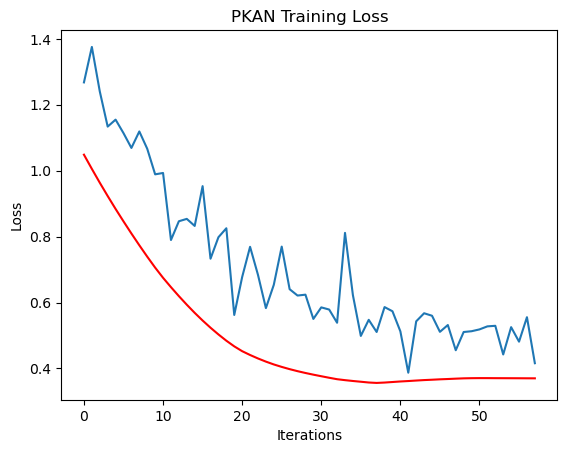

PKAN Training Complete!
Validation Loss: 0.3700
Mean Absolute Error (MAE): a=10.4278, b=0.0550
Mean Squared Error (MSE): a=168.1015, b=0.0091
Model saved to pkan_model.pth


In [7]:
train_data = EOS_Dataset(scale=True, train=True)
test_data = EOS_Dataset(scale=True, train=False)

eos_dataloader = EOS_Dataloader(train_data, test_data)

pkan_train_data = PKAN_Data(eos_dataloader)
pkan_test_data = PKAN_Data(eos_dataloader, False)

kan_layer = KANLayer(64, 64)

pkan = PKAN(kan_layer, pkan_train_data, pkan_test_data)

pkan.train_pkan()

pkan.validate_pkan(test_data)

pkan.save_model()

In [30]:


class Evolved_CNN(nn.Module):

    def __init__(self, dataloader, layers, fc_size):
        super(Evolved_CNN, self).__init__()

        self.dataloader = dataloader

        self.layers = layers

        self.output_layer = nn.Linear(fc_size, 2)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, predict=False):
        x = self.layers(x)
        if predict:
            x = self.output_layer(x)
        return x

    def weighted_loss(self, outputs, labels):
        criterion = nn.SmoothL1Loss()
        loss = criterion(outputs, labels)
        weight = torch.tensor([1.0, 80], device=device)  # Adjust if needed
        return (loss * weight).mean()

    def train_model(self, epochs=100, learning_rate=0.0001, patience=10, min_delta=0.001):
        optimizer = optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

        self.to(device)  # Move the model to GPU if available

        loss_history = []
        val_history = []

        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_weights = None

        for epoch in range(epochs):
            running_loss = 0.0
            running_val = 0.0

            for data in self.dataloader.train_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(inputs, predict=True)
                loss = self.weighted_loss(outputs, labels)
                loss_history.append(loss.item())
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                val_loss = self.train_val()
                val_history.append(val_loss.item())
                running_val += val_loss.item()

            avg_val_loss = running_val / len(self.dataloader.test_loader)
            scheduler.step(avg_val_loss)

            # Early Stopping Logic
            if avg_val_loss < best_val_loss - min_delta:
                best_val_loss = avg_val_loss
                best_model_weights = self.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                break

        # Restore best model before returning
        if best_model_weights:
            self.load_state_dict(best_model_weights)

        return loss_history, val_history


    def train_val(self):

        with torch.no_grad():
            imgs, labels = next(iter(self.dataloader.test_loader))
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = self(imgs, predict=True)
            loss = self.weighted_loss(outputs, labels)
        return loss

    def save_model(self, file_path="cnn_model.pth"):

        del self.output_layer

        torch.save(self.state_dict(), file_path)
        print(f"Model saved to {file_path}")

class CNN_GA():

    def __init__(self):
        self.NUM_CONV_LAYERS = [2, 3, 4]  # Number of convolutional layers
        self.NUM_FILTERS = [32, 64, 128, 256]  # Filters per layer
        self.KERNEL_SIZES = [3, 5]  # Kernel sizes
        self.FC_SIZES = [64, 128, 256]  # Fully connected layer size
        self.DROPOUT_RATES = [0.1, 0.2, 0.3]  # Dropout rates

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)
        self.toolbox = base.Toolbox()
        self.toolbox.register("num_conv", random.choice, self.NUM_CONV_LAYERS)
        self.toolbox.register("filters", random.choices, self.NUM_FILTERS, k=4)  # Max 4 layers
        self.toolbox.register("kernel_sizes", random.choices, self.KERNEL_SIZES, k=4)
        self.toolbox.register("fc_size", random.choice, self.FC_SIZES)
        self.toolbox.register("dropout", random.choice, self.DROPOUT_RATES)
        self.toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (self.toolbox.num_conv, self.toolbox.filters, self.toolbox.kernel_sizes, self.toolbox.fc_size, self.toolbox.dropout), n=1)

        # Population
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)

        # Register genetic operators
        self.toolbox.register("evaluate", self.evaluate)
        self.toolbox.register("mate", tools.cxTwoPoint)  # Crossover
        self.toolbox.register("select", tools.selTournament, tournsize=3) # Selection

        self.toolbox.register("mutate", self.custom_mutate)


        return
    
    def custom_mutate(self, individual):
        num_conv = individual[0]

        if random.random() < 0.2:
            individual[0] = random.choice(self.NUM_CONV_LAYERS)
            num_conv = individual[0]

        if random.random() < 0.2:
            individual[1:num_conv+1] = random.choices(self.NUM_FILTERS, k=num_conv)

        if random.random() < 0.2:
            individual[num_conv+1:2*num_conv+1] = random.choices(self.KERNEL_SIZES, k=num_conv)

        if random.random() < 0.2:
            individual[-2] = random.choice(self.FC_SIZES)

        if random.random() < 0.2:
            individual[-1] = random.choice(self.DROPOUT_RATES)

        return (individual,)

    
    def build_cnn(self, individual):
        num_conv = individual[0]
        filters = individual[1:num_conv+1]
        kernel_sizes = individual[num_conv+1:2*num_conv+1]
        fc_size = individual[-2]
        dropout_rate = individual[-1]

        print(f"num_conv: {num_conv}")
        print(f"filters: {filters}")
        print(f"kernel_sizes: {kernel_sizes}")   

        layers = []
        in_channels = 3  # RGB images

        for i in range(num_conv):
            layers.append(nn.Conv2d(in_channels, filters[i], kernel_size=kernel_sizes[i], padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = filters[i]

        # Get output feature size for FC layer
        dummy_input = torch.randn(1, 3, 300, 300)
        conv_out = nn.Sequential(*layers)(dummy_input)
        out_features = conv_out.view(-1).shape[0]  # Flatten and count features

        layers.append(nn.Flatten())
        layers.append(nn.Linear(out_features, fc_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(fc_size, 64))
        layers.append(nn.ReLU())

        CNN = Evolved_CNN(eos_dataloader, nn.Sequential(*layers), fc_size)
        return CNN

    
    def evaluate(self, individual):
        cnn = self.build_cnn(individual)
        t_loss, v_loss = cnn.train_model(epochs=50, learning_rate=0.0001, patience=10, min_delta=0.001)
        return (v_loss,) # deap requires a tuple
    
    def run_ga(self):
        pop = self.toolbox.population(n=10)  # Population size 10
        hof = tools.HallOfFame(1)  # Store the best individual
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("min", np.min)
        stats.register("avg", np.mean)
    
        algorithms.eaSimple(pop, self.toolbox, cxpb=0.5, mutpb=0.2, ngen=20,  # 20 generations
                            stats=stats, halloffame=hof, verbose=True)
        
        print("Best CNN found:", hof[0])

In [34]:
genetic_cnn_search = CNN_GA()

genetic_cnn_search.run_ga()

num_conv: 3
filters: [[32, 128, 32, 32], [5, 3, 3, 5], 64]
kernel_sizes: [0.1]


TypeError: unsupported operand type(s) for %: 'list' and 'int'